## Part 1: Pulse Rate Algorithm

### Dataset
This project utilizes the **Troika**[1] dataset to build the algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder explains how to interpret the data.  As well, see further explanation in notebook below.

**Reference**: Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

In [ ]:
import os
import glob
import itertools

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut

from sklearn.tree import export_graphviz
import IPython, graphviz, re, math

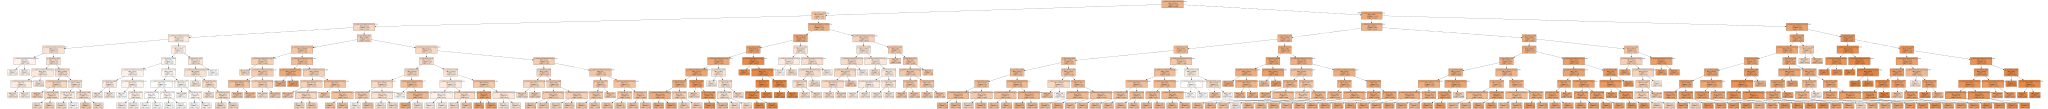

8.742091776176132


,max_tree_depth,mean_diff
0,2,18.882451
1,3,18.020774
2,4,17.210713
3,5,17.116638
4,6,16.784910
5,7,16.520013
6,8,16.573025
7,9,16.456763
8,10,16.681564
9,11,16.718270


In [2]:
fs = 125
window_length = 8
window_shift = 2
pass_band = (40/60, 240/60)

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def GetStartEndIdxs(signal_length, ground_truth_length, fs=125, window_length=8, window_shift=2):
    """
    Calculates the windowing indices for iterating through signal data. 

    Args:
        signal_length (number): The length of signal from accelerometer data
        ground_truth_length (number): The length of signal from PPG data
        fs (number): The sampling rate (number of samples per second)
        window_length (number): The length of sampling window (seconds)
        window_shift (number): The shift of sampling window (seconds)

    Returns:
        Windowing step indices 
    """
    # set matching length for signal and ground truth
    if ground_truth_length < signal_length:
        n = ground_truth_length
    else:
        n = signal_length
    
    # calculate window steps
    start_idxs = (np.cumsum(np.ones(n) * fs * window_shift) - fs * window_shift).astype(int)
    end_idxs = start_idxs + window_length * fs
   
    return start_idxs, end_idxs


def BandpassFilter(signal, pass_band=(40/60, 240/60), fs=125):
    """
    Filters data for a selected range of frequency data. 

    Args:
        signal (np.array): data to be filtered
        pass_band (tuple): range of frequencies to pass through
        fs (number): sampling rate of data (seconds)

    Returns:
        The filtered output with the same shape as original signal 
    """
    # butterworth filter applied
    b, a = sp.signal.butter(5, pass_band, btype='bandpass', fs=fs)
    # apply a digital filter forward and backward to a signal
    return sp.signal.filtfilt(b, a, signal)


def Featurize(ppg, accx, accy, accz):
    """
    Builds features from subject ppg and accelerometer data. 

    Args:
        ppg (np.array): single band ppg array
        accx (np.array): single band accelerometer array in x dimension
        accy (np.array): single band accelerometer array in y dimension
        accz (np.array): single band accelerometer array in z dimension

    Returns:
        feature (np.array): dominant freq of each ppg and accelerometers
        fourier (tuple): fourier frequencies and coeffients for ppg
    """

    # window (8 sec) of band filtered ppg data 
    n = len(ppg) * 3
    
    # perform fast fourier transform
    freqs = np.fft.rfftfreq(n, 1/fs)
    ppg_fft = np.abs(np.fft.rfft(ppg,n))
    
    # L2 Norm magnitude
    acc_mag = np.sqrt(accx**2 + accy**2 + accz**2)
    acc_fft = np.abs(np.fft.rfft(acc_mag, n))
    acc_fft[freqs <= 40/60.0] = 0.0
    acc_fft[freqs >= 240/60.0] = 0.0
    
    # get the dominant freq
    ppg_feature = freqs[np.argmax(ppg_fft)]
    acc_feature = freqs[np.argmax(acc_fft)]
    
    return np.array([ppg_feature, acc_feature]), (freqs, ppg_fft)

def GenerateFeatures(data_fls, ref_fls, fs=125, window_length=8, window_shift=2):
    """
    Extract features from the dataset.

    Generate features by sliding a window across each dataset and computing
    the features on each window.

    Args:
        data_fls: data files as returned by LoadTroikaDataset()
        ref_fls: reference ground truth files as returned by LoadTroikaDataset()
        fs (number): The sampling rate (number of samples per second)
        window_length (number): The length of sampling window (seconds)
        window_shift (number): The shift of sampling window (seconds)

    Returns:
        A 3-tuple:
        labels: (np.array) target data
        subjects: (np.array) The subject id that the datapoint came from
        features: (np.array) 2D Array, n_samples X n_features. The feature matrix.
    """
    # create lists to fit model and perform leave one group out cross-validation
    labels, features, subjects = [], [], []
    
    # iterate through subject data
    for data_fl, ref_fl in (zip(data_fls, ref_fls)):

        # unpack individual channel data
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
        # ground truth
        ref = scipy.io.loadmat(ref_fl)['BPM0'].reshape(-1)

        # get windowing steps for creating features
        start_idxs, end_idxs = GetStartEndIdxs(len(accx), len(ref))
        
        # parse unique subject from file path
        subject = os.path.basename(data_fl).split('.')[0]  
        
        # iterate over windows and filter for frequency range (bps between 40 and 240)
        for i, start_idx in enumerate(start_idxs):

            bp_ppg =  BandpassFilter(ppg[start_idx:end_idxs[i]])
            bp_accx = BandpassFilter(accx[start_idx:end_idxs[i]])
            bp_accy = BandpassFilter(accy[start_idx:end_idxs[i]])
            bp_accz = BandpassFilter(accz[start_idx:end_idxs[i]])

            # get dominant frequencies for ppg and accelerometer
            feature, fourier = Featurize(bp_ppg, bp_accx, bp_accy, bp_accz)
            
            # package ground truth, features, and subjects
            labels.append(ref[i])
            features.append(feature)
            subjects.append(subject)

    return (np.array(labels), np.array(subjects), np.array(features))

def DrawTree(t, col_names, size=128, precision=2, ratio='compress'):
    """ 
    Draws a representation of a decision tree or random forest in IPython.
    
    Args:
        t: The tree you wish to draw
        df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=col_names, filled=True,
                      special_characters=True, rotate=False, precision=precision)
    
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}',s)))


def CreateModel():
    """
    Generates regression model fit to dataset using leave one group out cross-validation.

    Returns:
        reg (model): Chosen regression model from scikit-learn library
        mean_diff: (number) evaluation metric
        feature_importances: (np.array) evaluation metric
    """
    max_tree_depth_opt = range(2, 12)   
    models = []
    mean_diffs = []
    feature_imports = []
    accuracy_table = []
        
    # load data and ground truth
    data_fls, ref_fls = LoadTroikaDataset()

    # featurize
    labels, subjects, features = GenerateFeatures(data_fls, ref_fls)
    
    #for multiple hyperparameters,,, in itertools.product(multiple hyperparameters,,,):
    for max_tree_depth in max_tree_depth_opt:

        # choose model
        #reg = RandomForestRegressor(n_estimators=400,max_depth=15) 
        #reg = GradientBoostingRegressor(n_estimators=400)        
        #reg = AdaBoostRegressor(n_estimators=400, learning_rate=1.0) 
        #reg = LinearRegression() 
        reg = DecisionTreeRegressor(max_depth=max_tree_depth, random_state=49)

        # split, fit, and cross-validate
        logo = LeaveOneGroupOut()
        means = []
        for train_idx, test_idx in logo.split(features, labels, subjects):
            X_train, y_train = features[train_idx], labels[train_idx]
            X_test, y_test = features[test_idx], labels[test_idx]
            reg.fit(X_train, y_train)
            y_pred = reg.predict(X_test)
            diff = np.mean(np.abs(y_pred - y_test))
            means.append(diff)

        splits = logo.get_n_splits(features, labels, subjects)
        mean_diff = np.mean(means)
        feature_importances = reg.feature_importances_
          
        models.append(reg)
        mean_diffs.append(mean_diff)
        feature_imports.append(feature_importances)
        accuracy_table.append((max_tree_depth, mean_diff))
        
    idx = np.argmin(mean_diffs)
    col_names =[features[0], features[1]]
    DrawTree(models[idx], col_names)
    
    return (models[idx], mean_diffs[idx], feature_imports[idx], accuracy_table)


def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Runs the regression model for each subject in dataset. 

    Args:
        data_fl (string): filepath for subject ppg and accelerometer data
        ref_fl (string): filepath for subject ground truth heart rate

    Returns:
        errors (np.array): absolute difference between predictions and ground truth (mean absolute error)
        confidences (np.array): power of confidence per prediction
    """

    errs = []
    confs = []

    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ref = scipy.io.loadmat(ref_fl)['BPM0'].reshape(-1)
   
    # get windowing steps
    start_idxs, end_idxs = GetStartEndIdxs(len(accx), len(ref))
    
    # per window
    for i, start in enumerate(start_idxs):

        # perform bandpass limiting from 40 to 240 bpm
        bp_ppg =  BandpassFilter(ppg[start:end_idxs[i]])
        bp_accx = BandpassFilter(accx[start:end_idxs[i]])
        bp_accy = BandpassFilter(accy[start:end_idxs[i]])
        bp_accz = BandpassFilter(accz[start:end_idxs[i]])
        
        # featurize and get ppg fourier freqs and coefficients
        feature, fourier = Featurize(bp_ppg, bp_accx, bp_accy, bp_accz)
        
        # Compute pulse rate estimates and estimation confidence.
        est = model.predict(np.reshape(feature, (1, -1)))[0]                                            \

        # unpack fourier freqs and coefficients
        freqs, fft = fourier

        # convert from bpm to hz and get small window for comparison
        est_fs = est / 60.0  
        fs_win = 15  / 60.0
        fs_win_e = (freqs >= est_fs - fs_win) & (freqs <= est_fs +fs_win)
        
        # compute power of confidence
        conf = np.sum(fft[fs_win_e])/np.sum(fft)

        # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
        errs.append(np.abs(est - ref[i]))
        confs.append(conf)
    
    return np.array(errs), np.array(confs)

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    
    # Run the pulse rate algorithm on each trial in the dataset
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
    
    # Compute aggregate error, confidence metrics
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

model, mean_diff, feature_importances, accuracy_table = CreateModel()
print(Evaluate())

accuracy_table_df = pd.DataFrame(accuracy_table, columns=['max_tree_depth', 'mean_diff'])
accuracy_table_df

### Original Data Description (Reference Notes)

#### Experiment descriptions and data format: 
Z.  Zhang,  Z.  Pi,  B.  Liu, TROIKA: A  general  framework  for  heart  rate  monitoring  using  wrist-type photoplethysmographic signals during intensive physical exercise, IEEE Transactions on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015, DOI: 10.1109/TBME.2014.2359372  

Two-channel   PPG   signals,   three-axis   acceleration   signals,   and   one-channel   ECG   signals   were simultaneously  recorded  from  subjects  with  age  from  18  to  35.  For  each  subject,  the  PPG  signals were  recorded  from  wrist  by  two  pulse  oximeters  with  green  LEDs  (wavelength:  515nm).  Their distance (from center to center) was 2 cm. The acceleration signal was also recorded from wrist by a three-axis  accelerometer.  Both  the  pulse  oximeter  and  the  accelerometer  were  embedded  in  a wristband, which was comfortably worn. The ECG signal was recorded simultaneously from the chest using  wet  ECG  sensors.  All  signals  were  sampled  at  125  Hz  and  sent  to  a  nearby  computer  via Bluetooth.  

Each dataset with the similar name 'DATA_01_TYPE01' contains a variable 'sig'. It has 6 rows. The first row  is  a  simultaneous  recording  of  ECG,  which  is  recorded  from  the  chest  of  each  subject.  The second  row  and  the  third  row  are  two  channels  of  PPG,  which  are  recorded  from  the  wrist  of  each subject. The last three rows are simultaneous recordings of acceleration data (in x-, y-, and z-axis).  

During  data  recording,  each  subject  ran  on  a  treadmill  with  changing  speeds.  For  datasets  with names containing 'TYPE01', the running speeds changed as follows:                      
rest(30s) -> 8km/h(1min) -> 15km/h(1min) -> 8km/h(1min) -> 15km/h(1min) -> rest(30s)  

For datasets with names containing 'TYPE02', the running speeds changed as follows:                      
rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)  

For  each  dataset  with  the  similar  name  'DATA_01_TYPE01',  the  ground-truth  of  heart  rate  can  be calculated from the simultaneously recorded ECG signal (i.e. the first row of the variable 'sig'). For convenience, we also provide the calculated ground-truth heart rate, stored in the datasets with the corresponding name, say 'REF_01_TYPE01'. In each of this kind of datasets, there is a variable 'BPM0', which  gives  the  BPM  value  in  every  8-second  time  window.  Note  that  two  successive  time  windows overlap  by  6  seconds. Thus  the  first  value  in  'BPM0'  gives  the  calcualted  heart  rate  ground-truth  in the  first  8  seconds,  while  the  second  value  in  'BPM0'  gives  the  calculated  heart  rate  ground-truth from the 3rd second to the 10th second.  

### Initial Naive Data Exploration

In [3]:
data_fls, ref_fls = LoadTroikaDataset()

In [4]:
data = sp.io.loadmat(data_fls[0])
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Aug 12 01:04:51 2014',
 '__version__': '1.0',
 '__globals__': [],
 'sig': array([[-2.695e+02, -2.675e+02, -2.675e+02, ..., -1.885e+02, -2.090e+02,
         -2.320e+02],
        [-2.300e+01, -2.400e+01, -2.650e+01, ...,  6.700e+01,  8.450e+01,
          1.000e+02],
        [ 4.000e+00,  6.000e+00,  3.000e+00, ...,  8.600e+01,  1.040e+02,
          1.185e+02],
        [-7.020e-02, -7.020e-02, -5.460e-02, ...,  4.134e-01,  4.134e-01,
          4.134e-01],
        [ 3.432e-01,  3.588e-01,  3.666e-01, ..., -2.808e-01, -2.730e-01,
         -2.730e-01],
        [ 9.594e-01,  9.438e-01,  9.360e-01, ...,  7.254e-01,  7.176e-01,
          7.254e-01]])}

In [5]:
data['sig'].shape

(6, 37937)

In [6]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

In [7]:
ppg, accx, accy, accz

(array([  4. ,   6. ,   3. , ...,  86. , 104. , 118.5]),
 array([-0.0702, -0.0702, -0.0546, ...,  0.4134,  0.4134,  0.4134]),
 array([ 0.3432,  0.3588,  0.3666, ..., -0.2808, -0.273 , -0.273 ]),
 array([0.9594, 0.9438, 0.936 , ..., 0.7254, 0.7176, 0.7254]))

In [8]:
ref = scipy.io.loadmat(ref_fls[0])
ref

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Aug 12 01:00:33 2014',
 '__version__': '1.0',
 '__globals__': [],
 'BPM0': array([[ 74.33920705],
        [ 76.35746606],
        [ 77.14285714],
        [ 74.66814159],
        [ 72.58064516],
        [ 71.68458781],
        [ 72.89416847],
        [ 73.44940152],
        [ 75.33482143],
        [ 76.8442623 ],
        [ 79.5990566 ],
        [ 79.11392405],
        [ 74.50331126],
        [ 70.83825266],
        [ 69.58762887],
        [ 71.94244604],
        [ 77.31958763],
        [ 80.29978587],
        [ 82.87292818],
        [ 83.51893096],
        [ 84.65011287],
        [ 88.23529412],
        [ 90.95920617],
        [ 92.87925697],
        [ 94.73684211],
        [ 97.28773585],
        [ 99.66777409],
        [101.58013544],
        [102.84810127],
        [103.44827586],
        [103.17460317],
        [102.95670539],
        [103.28389831],
        [104.05549626],
        [106.20915033],
        [108.

In [9]:
ground_truth = scipy.io.loadmat(ref_fls[0])['BPM0'].reshape(-1)
len(ground_truth)

148

In [10]:
print('sampling rate (fs): ', 125)
print('samples: ', len(ppg))
print('seconds: ', len(ppg)/125)
print('mintutes: ', len(ppg)/125/60)

sampling rate (fs):  125
samples:  37937
seconds:  303.496
mintutes:  5.0582666666666665


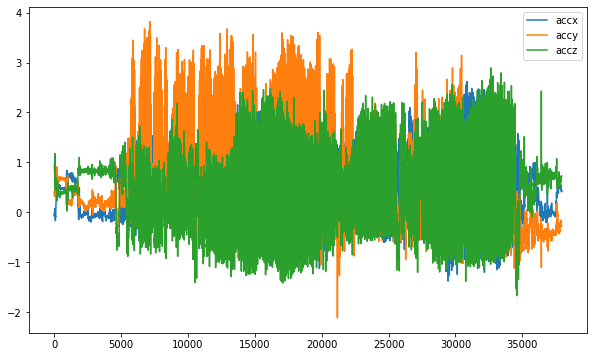

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(accx, label='accx')  
plt.plot(accy, label='accy')  
plt.plot(accz, label='accz')  
plt.legend()

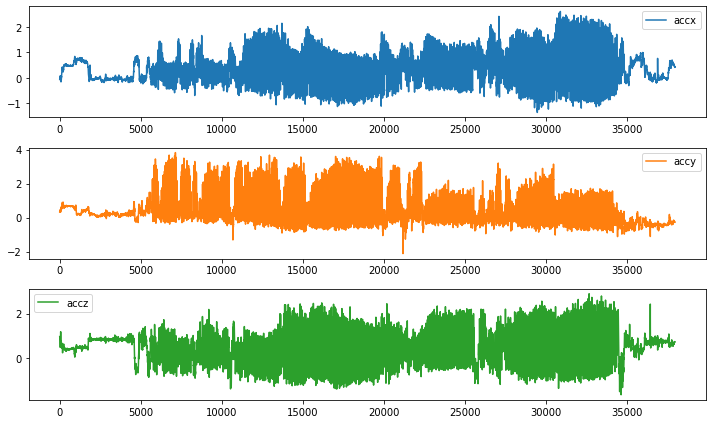

In [12]:
plt.figure(figsize=(10, 6))
plt.subplot(3,1,1)
plt.plot(accx, label='accx') 
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(accy, label='accy', color='C1')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(accz, label='accz', color='C2')
plt.legend()
plt.tight_layout()

In [13]:
def plot_fft(sig, fs, T, min_frame, max_frame):
    seg = sig[min_frame:max_frame]
    seg -= np.mean(seg) 
    fs = fs
    T = T
    ts = np.arange(0, T, 1/fs)

    fft = np.fft.rfft(seg)
    freq = np.fft.rfftfreq(len(seg), 1/fs)  
    
    fundamental = freq[np.argmax(np.abs(fft[(freq>0) & (freq<2)]))+1]
    #fundamental = freq[np.argmax(np.abs(fft[freq>0]))+1]
    print(f'fundamental frequency: {fundamental}')
    
    harmonics = fundamental* np.arange(1, 10)
        
    plt.figure(figsize=(10, 6))
    plt.clf()
    plt.subplot(2, 1, 1)
    plt.title('Time domain')
    plt.plot(ts[min_frame:max_frame], seg)
    plt.subplot(2, 1, 2)
    plt.title('Frequency domain')
    plt.plot(freq, np.abs(fft))
    plt.plot(harmonics, np.abs(fft[np.isin(freq, harmonics)]), 'r.', ms=10)
    plt.xlim(-0.5, 10)
    plt.tight_layout()

fundamental frequency: 1.875


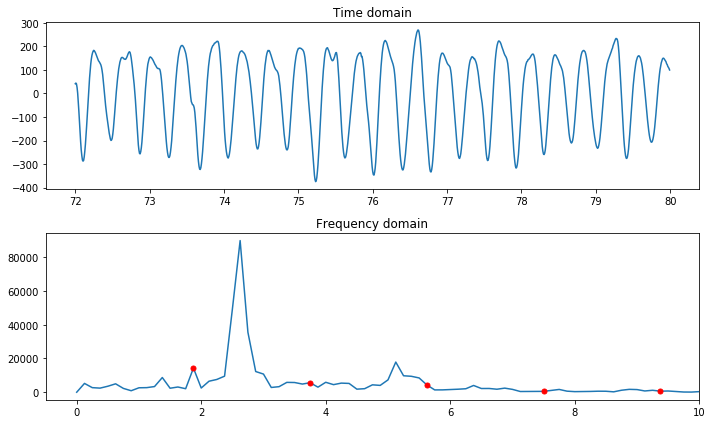

In [14]:
# signals = [ppg, accx, accy, accz]
# for s in signals:   

plot_fft(ppg, 125, 35000, 9000, 10000)

fundamental frequency: 1.25


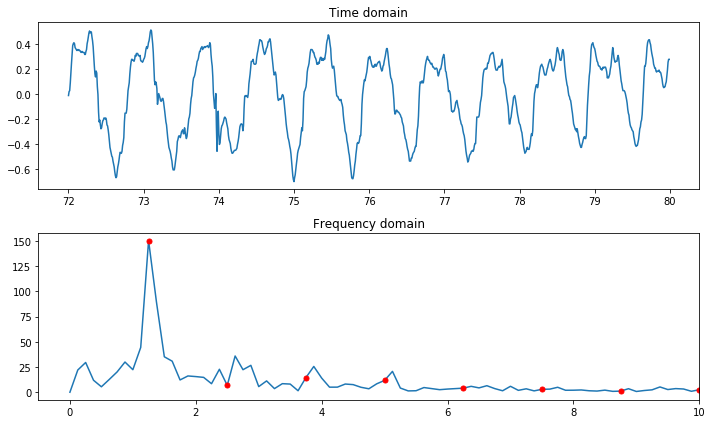

In [15]:
plot_fft(accx, 125, 35000, 9000, 10000)

fundamental frequency: 1.25


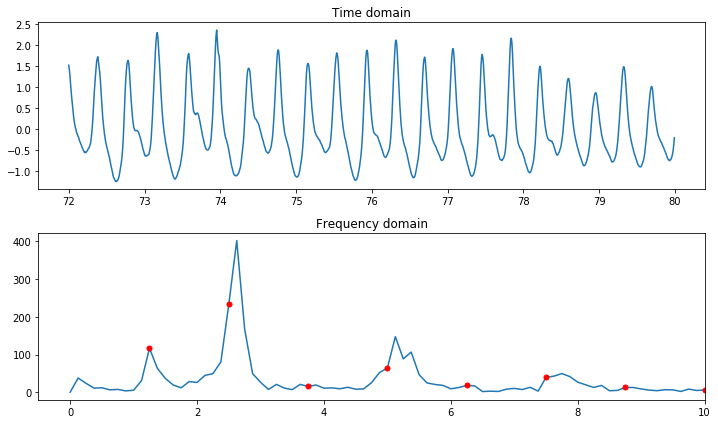

In [16]:
plot_fft(accy, 125, 35000, 9000, 10000)

fundamental frequency: 1.25


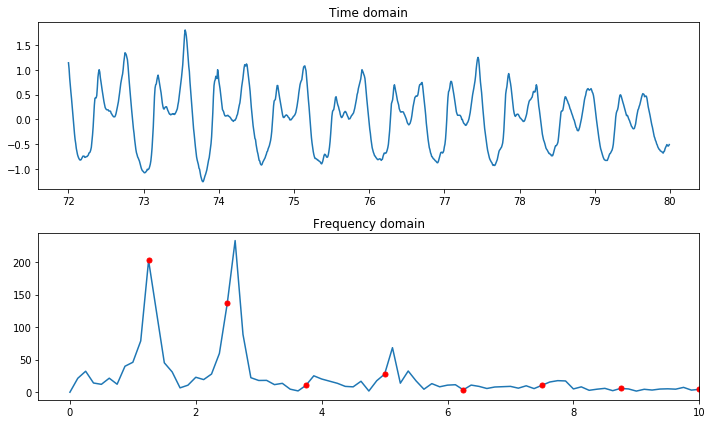

In [17]:
plot_fft(accz, 125, 35000, 9000, 10000)

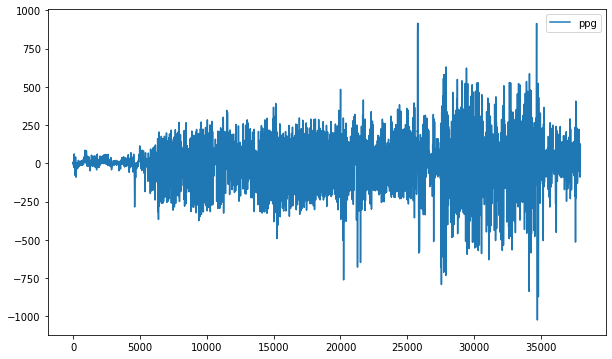

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(ppg, label='ppg') 
plt.legend()

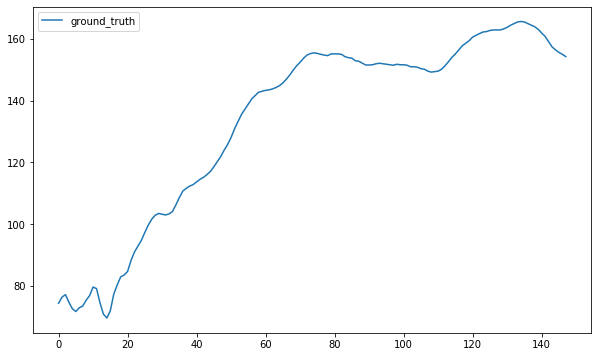

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(ground_truth, label='ground_truth')  
plt.legend()

Text(0, 0.5, 'Frequency (Hz)')

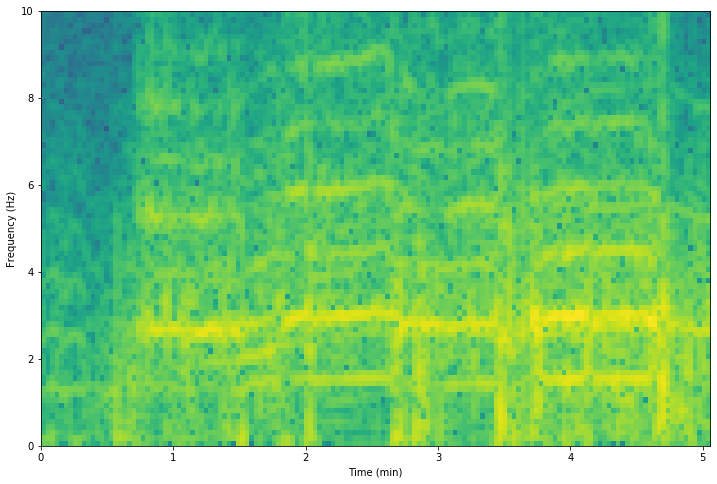

In [20]:
fs = 125
plt.figure(figsize=(12, 8))
ppg_spec, ppg_freqs, ppg_t, ppg_im = plt.specgram(ppg, Fs=fs, NFFT=1000, noverlap=750, xextent=[0, len(ppg) / fs / 60]);
plt.ylim(0,10)
plt.xlabel('Time (min)')
plt.ylabel('Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

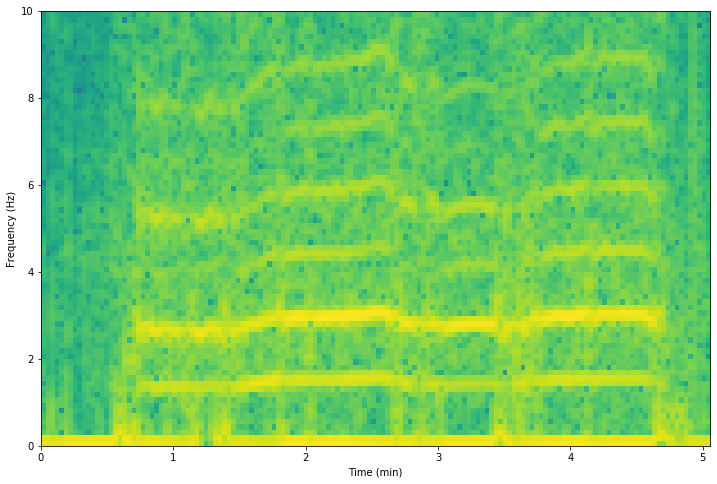

In [21]:
fs = 125
plt.figure(figsize=(12, 8))
acc_spec, acc_freqs, acc_t, acc_im = plt.specgram(accz+accy+accz, Fs=fs, NFFT=1000, noverlap=750, xextent=[0, len(accz) / fs / 60]);
plt.ylim(0,10)
plt.xlabel('Time (min)')
plt.ylabel('Frequency (Hz)')

In [22]:
dominant_freqs_ppg = ppg_freqs[np.argmax(ppg_spec, axis = 0)]
dominant_freqs_ppg

array([0.125, 0.125, 0.125, 1.25 , 1.125, 1.125, 1.25 , 0.   , 0.125,
       1.25 , 1.375, 1.375, 1.25 , 1.125, 1.125, 1.25 , 0.125, 0.125,
       0.125, 0.125, 1.25 , 2.625, 2.75 , 2.625, 2.625, 2.625, 2.625,
       2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.5  , 2.5  ,
       2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.5  , 0.125,
       2.75 , 2.75 , 2.75 , 2.75 , 2.125, 2.125, 2.125, 3.25 , 2.625,
       2.75 , 2.875, 2.875, 2.875, 3.   , 2.875, 2.875, 2.875, 2.875,
       2.875, 2.875, 2.875, 2.875, 2.875, 3.   , 3.   , 3.   , 3.   ,
       3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 2.625, 2.75 ,
       2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.625,
       2.625, 2.625, 2.75 , 2.75 , 2.875, 2.75 , 2.75 , 2.75 , 2.75 ,
       2.75 , 2.75 , 0.625, 2.375, 2.375, 0.125, 2.5  , 2.5  , 2.625,
       2.875, 3.   , 2.5  , 2.875, 2.875, 2.875, 3.   , 2.875, 2.875,
       2.875, 3.   , 3.   , 3.   , 2.625, 2.75 , 2.75 , 3.   , 3.   ,
       2.875, 3.   ,

In [23]:
dominant_freqs_acc = acc_freqs[np.argmax(ppg_spec, axis = 0)]
dominant_freqs_acc

array([0.125, 0.125, 0.125, 1.25 , 1.125, 1.125, 1.25 , 0.   , 0.125,
       1.25 , 1.375, 1.375, 1.25 , 1.125, 1.125, 1.25 , 0.125, 0.125,
       0.125, 0.125, 1.25 , 2.625, 2.75 , 2.625, 2.625, 2.625, 2.625,
       2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.5  , 2.5  ,
       2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.5  , 0.125,
       2.75 , 2.75 , 2.75 , 2.75 , 2.125, 2.125, 2.125, 3.25 , 2.625,
       2.75 , 2.875, 2.875, 2.875, 3.   , 2.875, 2.875, 2.875, 2.875,
       2.875, 2.875, 2.875, 2.875, 2.875, 3.   , 3.   , 3.   , 3.   ,
       3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 3.   , 2.625, 2.75 ,
       2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.75 , 2.625,
       2.625, 2.625, 2.75 , 2.75 , 2.875, 2.75 , 2.75 , 2.75 , 2.75 ,
       2.75 , 2.75 , 0.625, 2.375, 2.375, 0.125, 2.5  , 2.5  , 2.625,
       2.875, 3.   , 2.5  , 2.875, 2.875, 2.875, 3.   , 2.875, 2.875,
       2.875, 3.   , 3.   , 3.   , 2.625, 2.75 , 2.75 , 3.   , 3.   ,
       2.875, 3.   ,

In [24]:
fft = np.fft.rfft(ppg)

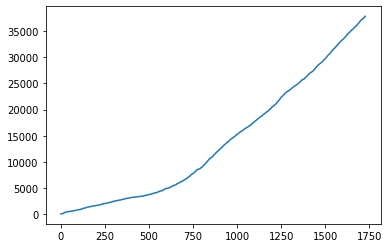

In [25]:
ppg_peaks, _ = scipy.signal.find_peaks(ppg, height=None, distance=1)
plt.plot(ppg_peaks)

### Project Write-Up

**Experiment / Code Description** 

The code presented herein is intended to estimate the heart rate in beats per minute from mutiple input signals taken from subjects during intense exercise.  These input signals include subject data from a photoplethysmogram (PPG) device which optically measures blood flow to the wrist and an accelerometer, an Inertial Measurement Unit (IMU) device, which records linear acceleration data along the 3 spatial dimensions as x, y, and z data points. We have ground truth recorded per subject concurrently as an electrocardiogram (ECG) signal.  Thus, we will set up our experiment as a supervised machine learning problem modeling with decision tree and ensemble based regressor models.

As the subject is exercising, the PPG signal will not only record the pulse rate oscillation, but other rhythmic activity during exercise, including arm cadence, as well as other motion. Signals due to motion will also be recorded in the accelerometer data, exclusive of the pulse rate.  So we can calculate a fourier transform on the PPG and accelerometer data, comparing data in the frequency domain, and can infer that the PPG signal not present in accelerometer data represents the pulse rate.

In summary, we have estimated the pulse rate from the PPG and 3D accelerometer signal data.  In so doing, we make the assumption that the pulse will be between 40 and 240 beats per minute (bpm) and we return a confidence estimate, selecting the most reliable estimates and computing mean absolute error(MAE) .  The resulting MAE at 90% availability is from 8-12 bpm.

To run algorithm,  implement CreateModel() and run Evaluate().

**Data Description** 

The data is recorded from 12 subjects, aging 18 to 35 years old.  The ppg signals were recorded on the wrist by two pulse oximeters with green LEDs at 515nm.  The 3D accelerometer data was also embedded in wristband.  The ECG ground truth was recorded from the chest.  All signals were sampled at 125 Hz.  Subject ran on a treadmill with changing speeds from range of 6km/hr-12km/hr or 8km/hr-15km/hr.

Data limitations include the amount and variety of data.  Signal length ranges from 220.61 seconds (3.68 minutes) to 326.42 seconds (5.44 minutes).  There are not a lot of subjects, subjects are limited in age range, further demographic data is unknown including gender, race, and any pertinent medical baseline information.  A greater amount of data in terms of recordings and representation would improve training outcomes.

**Algorithhm Description**

   - How the algorithm works:
   
     First, we prep the data by iterating through 8 second windows of data every 2 seconds.  We then bandpass filter the data to keep it within the 40 to 240 bpm range.  Next, we featurize the PPG and accelerometer data, using the fourier transformation to find dominant frequencies to be passed to our model for prediction.  We utilize a decision tree regressor model with a maximum depth of 9 nodes fit with leave one group out cross validation.  We then compute a confidence estimation of our predicted pulse rate by calculating the power of the signal.  We do this by summing the signal strength over a 15 bpm window around our predicted frequency and comparing this to the magnitudes over the total.
     
           
   - A description of the algorithm outputs:
   
     The algorithm outputs a confidence estimation which is our signal power as well as our estimation error as mean absolute error vis a vis the ground truth.  We then compute and return the mean absolute error at 90% availability as described above. 
     
   
   - Caveats on algorithm outputs: 
   
     The algorithm produces confidence and error estimates, but there may be sources of error variability not accounted for including hyperparameters such as window size and sampling rate. 
     
   
   - The specific aspects of the physiology that it takes advantage of:
   
     The PPG measures blood flow by shining a green light into the skin which is absorbed by red blood cells (RBC).  A photodetector measures the amount of light reflected back which is attenuated by the amount of red blood cells.  This absorptions flows with the phases of the heart beat, that is during systole, when ventricles contract the density of RBCs is greater and the signal reflected back is minimized, whereas during diastole as blood returns to the heart, the reflected light is maximized.  Thus we see a periodic cyclicity in the PPG signal corresponding to this physiology.  This oscillating waveform can be used to detect the pulse rate, i.e, the heart rate.  
     
   
   - Common failure modes:
   
     Though this is a dependable physiological waveform, the detection may encounter many confounding sources or noise interfering with the pure signal.  These include a number of factors including body position, arm position, and arm and finger motion.  Also, factors of sensor displacement on the wrist or ambient light may interefere with the signal.  Furthermore, between individuals, the amount of melanin, i.e. skin coloring, effects the baseline and quality of the signal.
   
     Further failure modes could entail depending on usage of algorithm.  This data is limited coming from an artificial laboratory environment with steady ambient light and static orientation on a treadmill.  If the algorithm were to be employed in another context, such as an athletic environment, many more factors would be at play including changing light, terrain, orientation, direction, etc.  So algorithm would be limited to medical lab or training setting versus outside performance or athletic scenario.  Again, performance may vary with demographic data such as gender, skin color, age, and other issues as well.
     
   
**Algorithm Performance** 

   The algorithm was trained using a decision tree regressor with leave one group out cross-validation.  Ensemble models were also tested including a random forest regressor, adaboost regressor, and gradient boosting regressor.  None of the ensemble methods outperformed the decision tree regressor on the training data.  Therefore, the decision tree regressor was chosen as an ensemble method is both slower to train and to make predictions as it has to run predictors through all training trees.
   
   The model did result in average error of 8.76 on the training set and 11.17 on the test set suggesting overfitting to the data.  An ensemble method would be better chosen to deal with this aspect of modelling as it would be less prone to overfitting and therefore generalize better.  Preliminary tests did not show a difference with the test set.  Hyperparameter tuning didn't result in a better model with ensemble methods, though a much more thorough process would well benefit that effort.
   
   Again, the resulting algorithm would benefit with greater amount and type of data represented in the dataset, as mentioned above.  This would help in making the algorithm more robust and able to generalize.  Subsequently, greater hyperparameter tuning and model testing as well as featurizing may improve performance. 
